### Import useful libraries

In [29]:
# Import useful libraries for computation
import numpy as np

# Import torch and libraries to deal with NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pyhessian import hessian 
import copy

# Import usefil library to visualize results
import matplotlib.pyplot as plt

# Importing the LeNet5 architecture we are going to use for our study and comparisons
from cnn_architectures import *

# Importing parameters to use with different optimizers before comparing them
import params

# Importing useful functions
from helpers import *

# Ignoring warnings to make the code more readable
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting the parameters and additional variables

In [30]:
# Defininig neural network's parameters and seed for reproducibility purposes
RANDOM_SEED = 42
IMG_SIZE = 32
N_CLASSES = 10
# Checking device
# Checking device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

### Loading, reshaping and plotting  data (SGD)

In [31]:
# Loading data
transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
raw_mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.SGD_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.SGD_BATCH_SIZE, 
                          shuffle=False)

In [32]:
# Reshaping train data (from 28*28 to 32*32) for visualization purposes
train_data, train_target = reshape_train_data(raw_mnist_trainset, DEVICE)
# Reshaping test data (from 28*28 to 32*32) for visualization purposes
test_data, test_target = reshape_test_data(raw_mnist_trainset, DEVICE)

## Model training and Model Evaluation using SGD

First, we train our model using LeNet5. The model was trained using batches of size 128 and 10 epochs. 

In [33]:
# Initializing the model we are going to use in our study
indices = np.random.choice(len(train_data),1000)
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)

data_for_spectral_gap = [hessian_input, hessian_label]

model = LeNet5(num_classes=N_CLASSES).to(DEVICE)
# Defining the criterion (loss function) to be used during the training procedure
criterion = nn.CrossEntropyLoss()
# Defining and initializing the optimizer (ADAM in this notebook)
optimizer = torch.optim.SGD(model.parameters(), lr=params.SGD_LEARNING_RATE)

Let's train and test our first model

In [34]:
model, optimizer, losses, grad_norms, spectral_gap = training_loop(model, criterion, optimizer, train_loader, test_loader, params.SGD_N_EPOCHS,
                                    DEVICE, data_for_spectral_gap)

16:56:11 --- Epoch: 0	Train loss: 2.2398	Valid loss: 2.0531	Train accuracy: 63.99	Valid accuracy: 64.69
16:56:33 --- Epoch: 1	Train loss: 1.3445	Valid loss: 0.8266	Train accuracy: 78.08	Valid accuracy: 78.98
16:56:56 --- Epoch: 2	Train loss: 0.6645	Valid loss: 0.5352	Train accuracy: 85.45	Valid accuracy: 85.95
16:57:18 --- Epoch: 3	Train loss: 0.4862	Valid loss: 0.4233	Train accuracy: 87.97	Valid accuracy: 88.54
16:57:41 --- Epoch: 4	Train loss: 0.4070	Valid loss: 0.3644	Train accuracy: 89.26	Valid accuracy: 89.83
16:58:03 --- Epoch: 5	Train loss: 0.3602	Valid loss: 0.3267	Train accuracy: 90.13	Valid accuracy: 90.52
16:58:26 --- Epoch: 6	Train loss: 0.3269	Valid loss: 0.2987	Train accuracy: 90.93	Valid accuracy: 91.31
16:58:48 --- Epoch: 7	Train loss: 0.2999	Valid loss: 0.2734	Train accuracy: 91.60	Valid accuracy: 92.00
16:59:11 --- Epoch: 8	Train loss: 0.2770	Valid loss: 0.2521	Train accuracy: 92.16	Valid accuracy: 92.68
Unexpected exception formatting exception. Falling back to stand

Traceback (most recent call last):
  File "/Users/riccardobrioschi/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/tg/7gjwf2pn3vxbksw0hk4k_5sm0000gn/T/ipykernel_3146/1093624427.py", line 1, in <module>
    model, optimizer, losses, grad_norms, spectral_gap = training_loop(model, criterion, optimizer, train_loader, test_loader, params.SGD_N_EPOCHS,
  File "/Users/riccardobrioschi/Desktop/OPT_PROJECT/helpers.py", line 176, in training_loop
    """
  File "/Users/riccardobrioschi/Desktop/OPT_PROJECT/helpers.py", line 90, in train
  File "/Users/riccardobrioschi/miniconda3/envs/torch/lib/python3.9/site-packages/pyhessian/hessian.py", line 141, in eigenvalues
    Hv = hessian_vector_product(self.gradsH, self.params, v)
  File "/Users/riccardobrioschi/miniconda3/envs/torch/lib/python3.9/site-packages/pyhessian/utils.py", line 82, in hessian_vector_product
   

In [9]:
plot_gradient_norm(grad_norms[-30:], method = 'SGD')

<Axes: xlabel='Predicted label', ylabel='True label'>

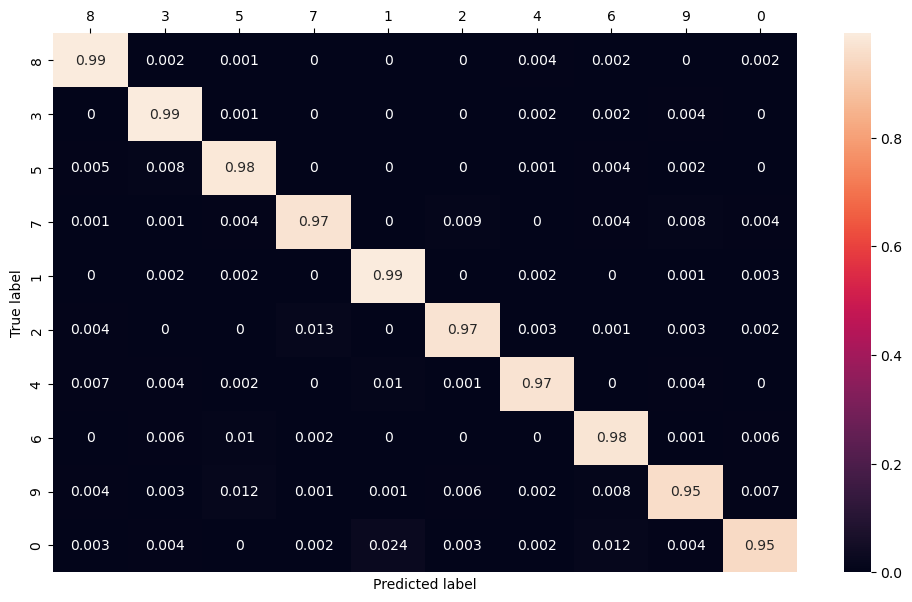

In [8]:
compute_confusion_matrix(test_loader, model, N_CLASSES)

In [9]:
# We now divide the training dataset into batches to compute the hessian of the loss evaluated in the solution
indices = np.random.choice(len(train_data),1000)
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)


# We now compute the hessian matrix, to later retrieve the spectral norm and the eigenvalues
device_flag = True if torch.cuda.is_available() else False
model_to_plot = copy.deepcopy(model)
criterion = torch.nn.CrossEntropyLoss()
hessian_comp = hessian(model_to_plot, criterion, data=(hessian_input, hessian_label), cuda=device_flag)

# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)

# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
print("The top eigenvalue of this model is: %.4f "% (top_eigenvalues[0]))

The top eigenvalue of this model is: 8.4430 


Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

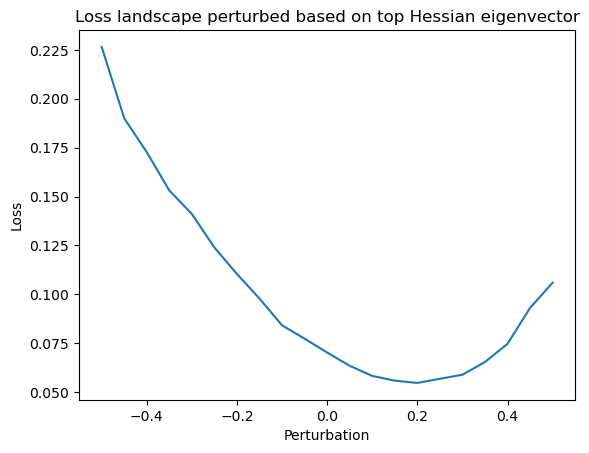

In [10]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# At first, we initialized the perturb model to be the model obtained at the end of the training procedure
model_perb = copy.deepcopy(model)

# We now perturb the function in the direction given by the top eigenvector to visualize the quality of the minimum
for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(hessian_input), hessian_label).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

Text(0.5, 1.0, 'Loss landscape perturbed based on gradient direction')

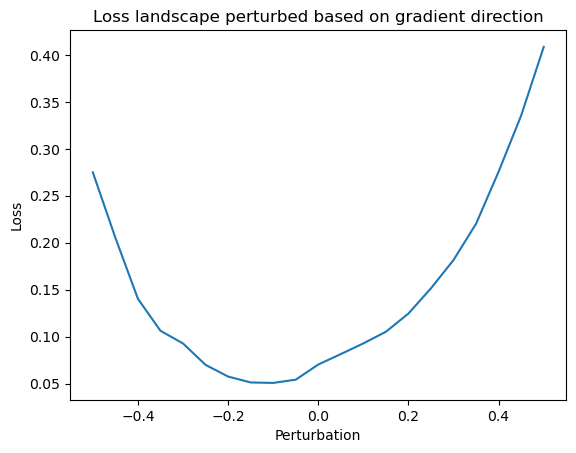

In [11]:
from pyhessian.utils import normalization


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)

# generate gradient vector to do the loss plot
loss = criterion(model_perb(hessian_input), hessian_label)
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(hessian_input), hessian_label).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on gradient direction')